In [46]:
!pip -q install -U FlagEmbedding
!pip install azure-identity

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Why ?
    - In retrivial you bring back large chunks and only very small amound those chunks may be relevant/useful to particular answer
    - Meaning of this is you bring lots of things to the table just to get a little bit of value out of it
    - so we used compressors & filters wipes out the things that are not relevant to the answer from the big data chunks
    - we have more built in compressors & filters
        -> LLMChainExtractor
                iterate over the initially returned documents and extract from each only the content that is relevant to the query.
        -> LLMChainFilter
                Uses an LLM chain to select out the queries to show the final LLM - This could be shown to a model fine tuned to do this. 
                "YES" we show it or "NO" we don't show it
        -> EmbeddingsFilter
                Use an Embedding model to filter out the results that are closest to the query (based on threshold)
        

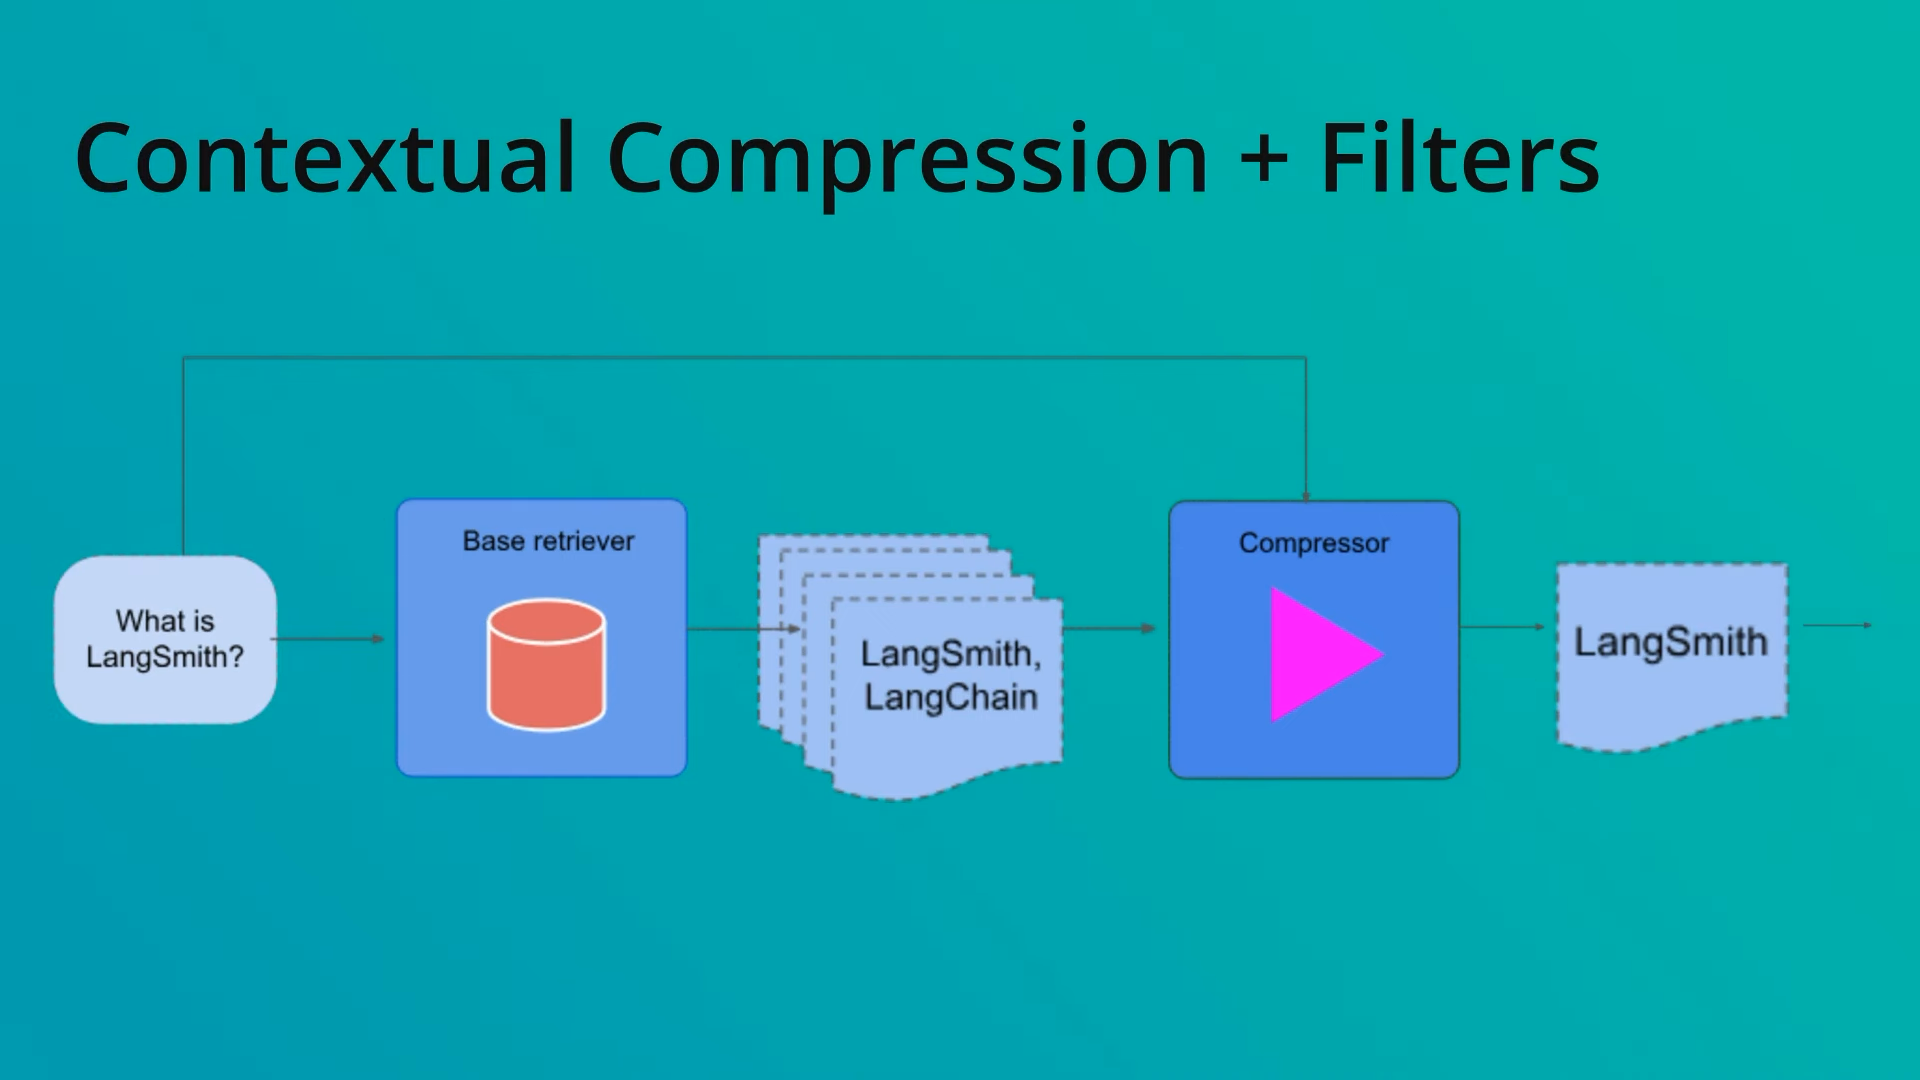

# How we do this ?

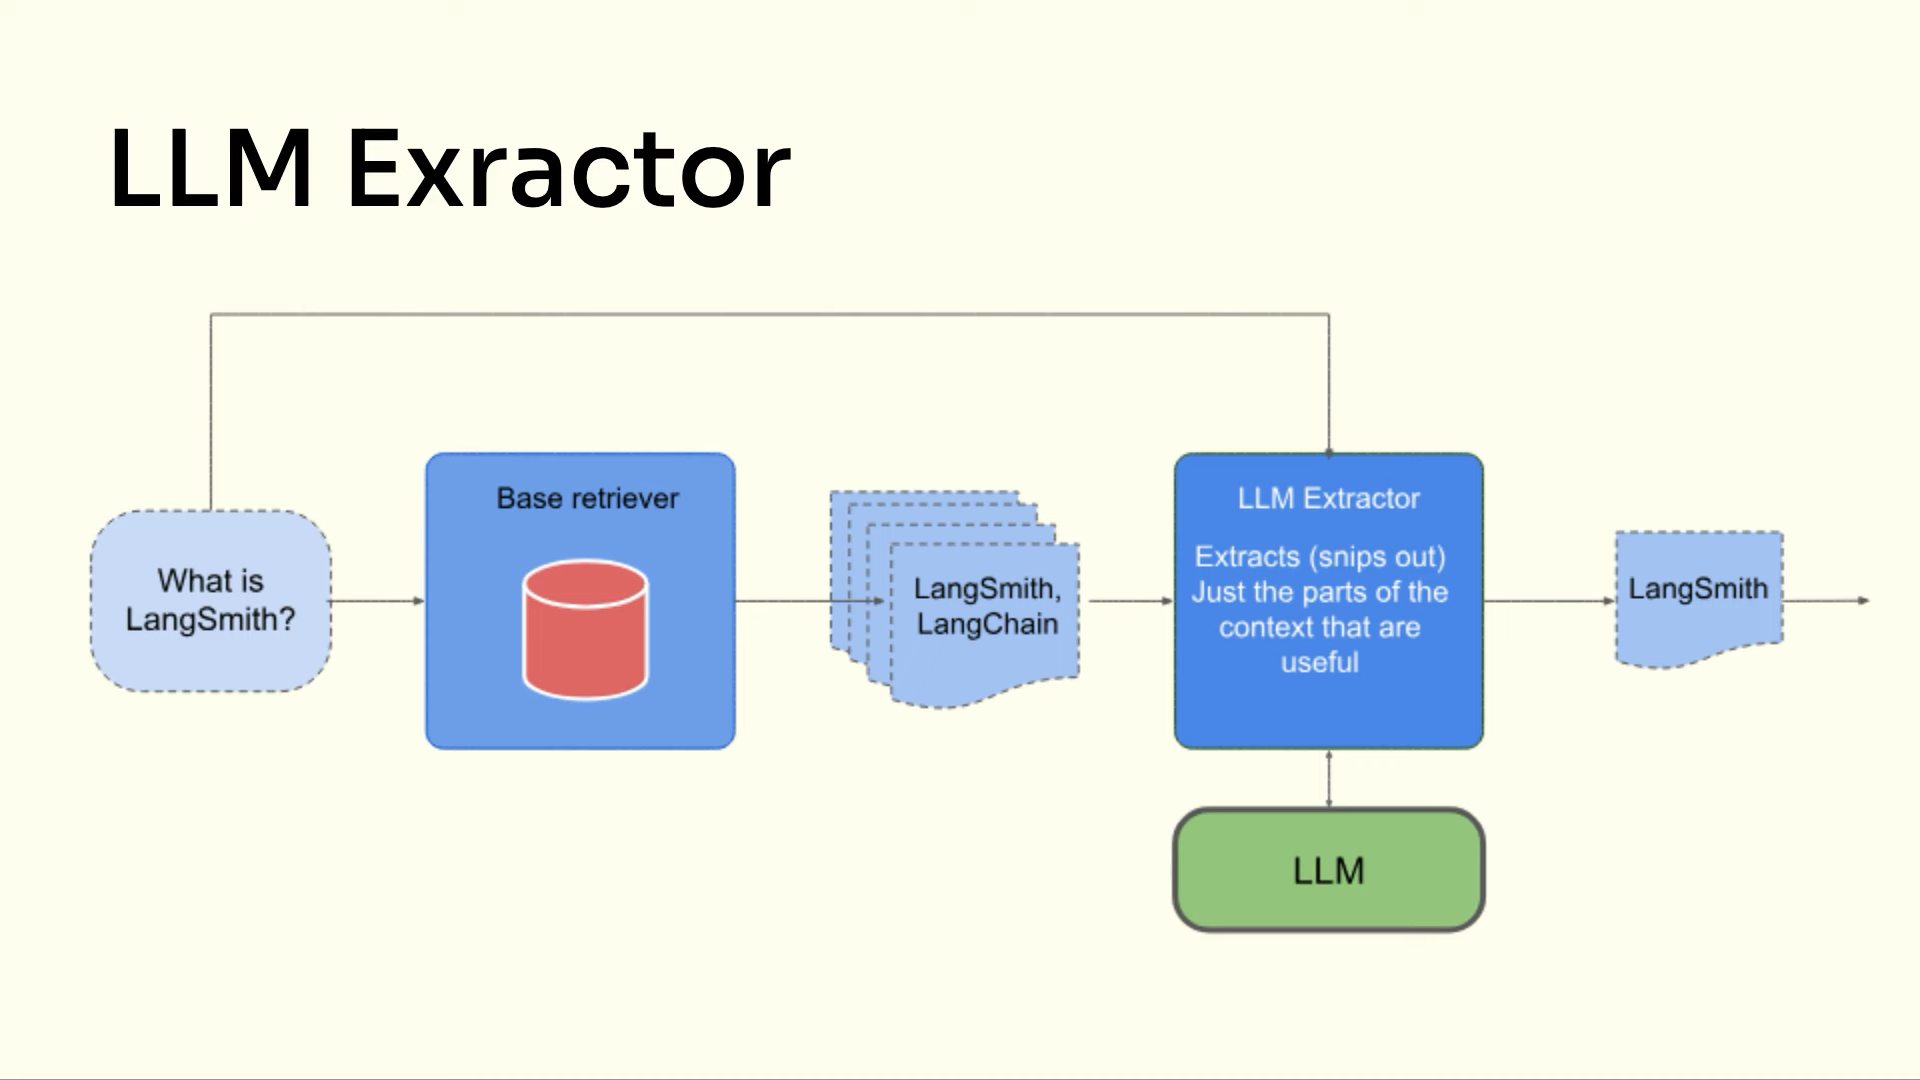

# You can even use specified finetuned LLM as the compressor
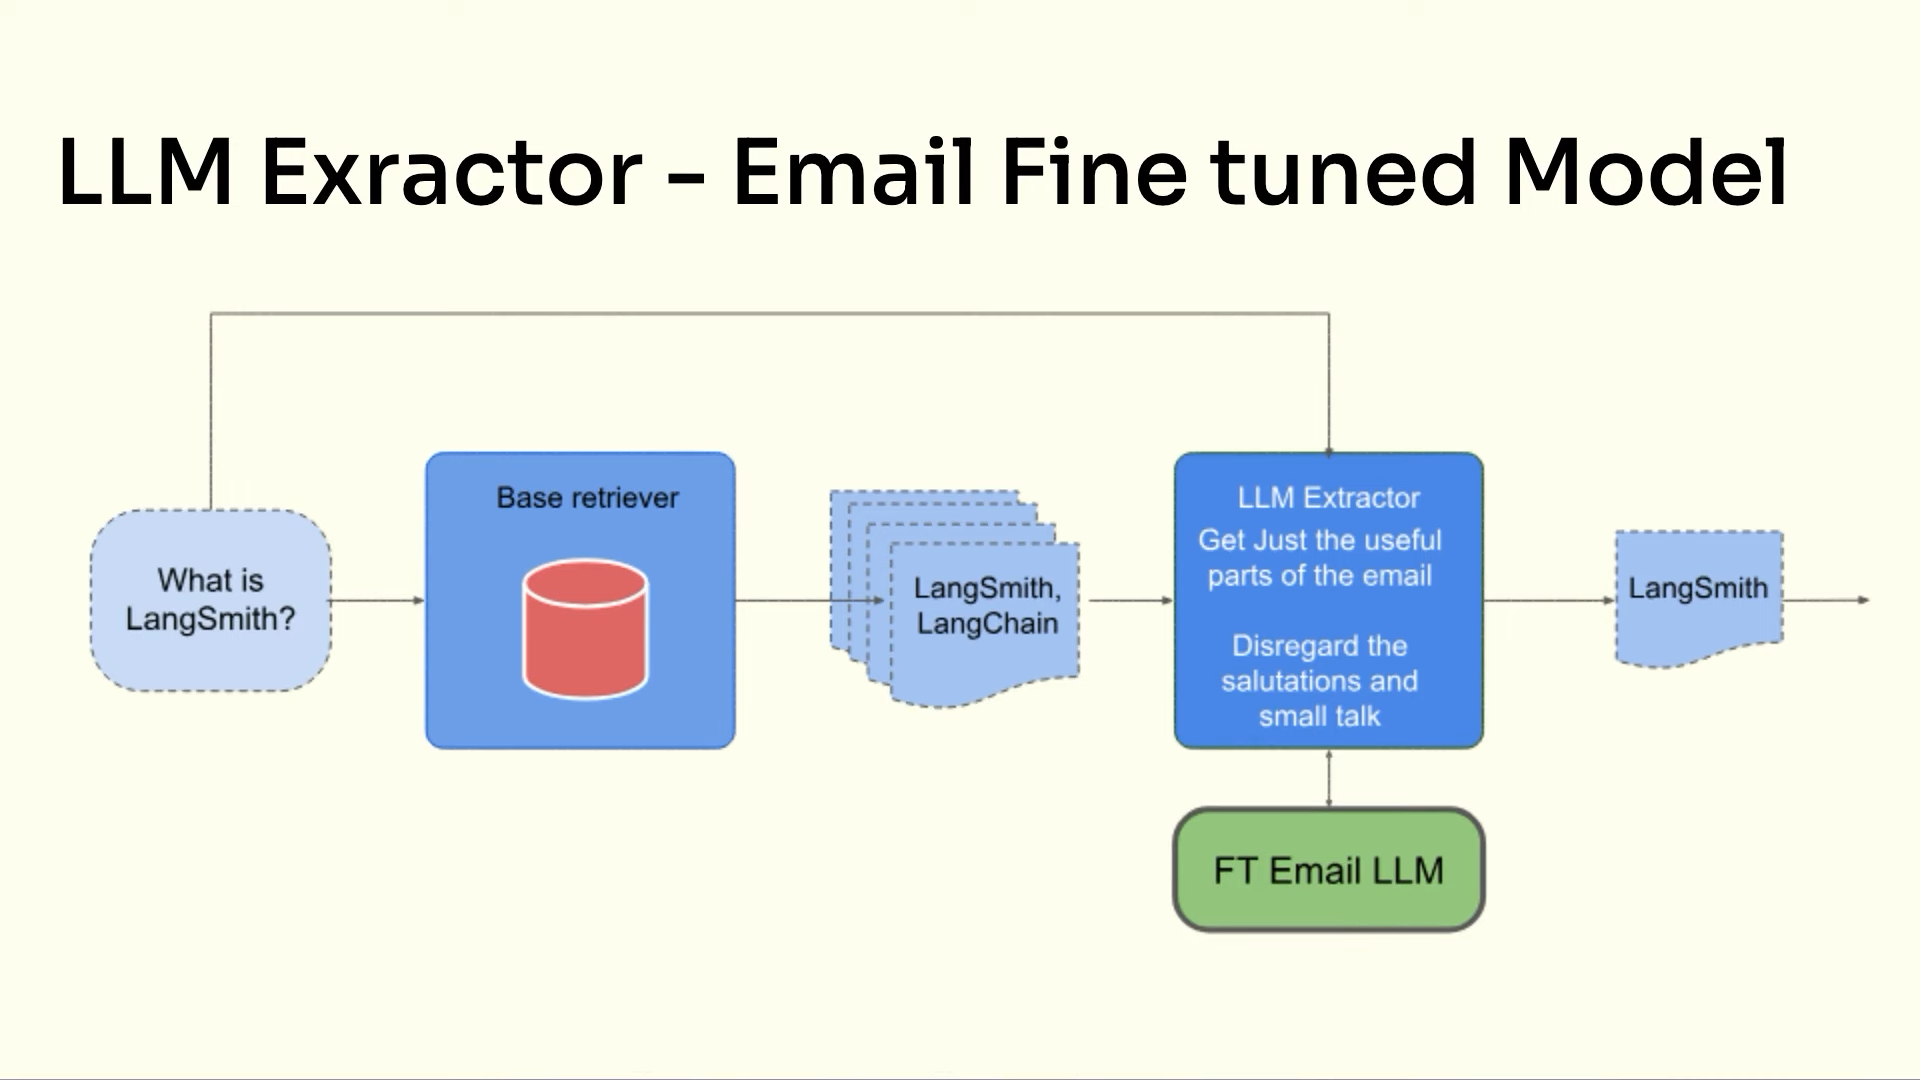

In [59]:
import yaml, os, openai, textwrap
from langchain.schema import Document
from langchain.llms import AzureOpenAI
from langchain.storage import InMemoryStore
from langchain.vectorstores import FAISS, Chroma
from langchain.document_loaders import TextLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.retrievers import ContextualCompressionRetriever
from langchain.text_splitter import (
                                        RecursiveCharacterTextSplitter, 
                                        CharacterTextSplitter
                                        )
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import (
                                                        DocumentCompressorPipeline,
                                                        LLMChainExtractor, 
                                                        EmbeddingsFilter, 
                                                        LLMChainFilter
                                                    )

In [48]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ["OPENAI_API_TYPE"] = credentials['AD_OPENAI_API_TYPE']
os.environ["OPENAI_API_VERSION"] = credentials['AD_OPENAI_API_VERSION']
os.environ["OPENAI_API_BASE"] = credentials['AD_OPENAI_API_BASE']
os.environ["OPENAI_API_KEY"] = credentials['AD_OPENAI_API_KEY']

In [49]:
bge_embeddings = HuggingFaceBgeEmbeddings(
                                        model_name="BAAI/bge-small-en-v1.5",
                                        model_kwargs={'device': 'mps'},
                                        encode_kwargs={'normalize_embeddings': True}
                                        )

llm = AzureChatOpenAI(
                    deployment_name=credentials['AD_DEPLOYMENT_ID'],
                    model_name=credentials['AD_ENGINE'],
                    temperature=0.9, 
                    max_tokens = 256
                    )

## data loading

In [50]:
loaders = [
        TextLoader('data/langchain_blog_posts/blog.langchain.dev_announcing-langsmith_.txt'),
        TextLoader('data/langchain_blog_posts/blog.langchain.dev_benchmarking-question-answering-over-csv-data_.txt'),
        ]

docs = []
for l in loaders:
    docs.extend(l.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

In [51]:
def pretty_print_docs(docs):
    
    '''Helper function for printing docs'''

    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [52]:
vector_store = FAISS.from_documents(
                                texts,
                                bge_embeddings
                                )
retriever = vector_store.as_retriever()

docs = retriever.get_relevant_documents("What is LangSmith?")

pretty_print_docs(docs)

Document 1:

“Because we are building financial products, the bar for accuracy, personalization, and security is particularly high. LangSmith helps us build products we are confident putting in front of users.”

We can’t wait to bring these benefits to more teams. And we’ve got a long list of features on the roadmap like analytics, playgrounds, collaboration, in-context learning, prompt creation, and more.
----------------------------------------------------------------------------------------------------
Document 2:

URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “n

## Adding contextual compression with an LLMChainExtractor

Now let's wrap our base retriever with a ContextualCompressionRetriever. We'll add an LLMChainExtractor, which will iterate <br> over the initially returned documents and extract from each only the content that is relevant to the query.

In [53]:
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
                                                        base_compressor=compressor,
                                                        base_retriever=retriever
                                                        )

In [54]:
# compressor prompt
print(textwrap.fill(compressor.llm_chain.prompt.template, 100))

Given the following question and context, extract any part of the context *AS IS* that is relevant
to answer the question. If none of the context is relevant return NO_OUTPUT.   Remember, *DO NOT*
edit the extracted parts of the context.  > Question: {question} > Context: >>> {context} >>>
Extracted relevant parts:


In [55]:
compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith?")
pretty_print_docs(compressed_docs)

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

LangSmith is a unified platform for debugging, testing, evaluating, and monitoring LLM applications.
----------------------------------------------------------------------------------------------------
Document 2:

LangSmith gives you full visibility into model inputs and output of every step in the chain of events.
----------------------------------------------------------------------------------------------------
Document 3:

LangSmith is a platform to help developers close the gap between prototype and production. It's designed for building and iterating on products that can harness the power and wrangle the complexity of LLMs. LangSmith is in closed beta and is a robust, unified system for debugging, testing, evaluating, and monitoring LLM applications.


# More built-in compressors: filters

## LLMChainFilter

Uses an LLM chain to select out the queries to show the final LLM - This could be shown to a model fine tuned to do this

"YES" we show it or "NO" we don't show it

In [56]:
_filter = LLMChainFilter.from_llm(llm)
print(textwrap.fill(_filter.llm_chain.prompt.template, 100))

Given the following question and context, return YES if the context is relevant to the question and
NO if it isn't.  > Question: {question} > Context: >>> {context} >>> > Relevant (YES / NO):


In [57]:
compression_retriever = ContextualCompressionRetriever(base_compressor=_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

Debugging

LangSmith gives you full visibility into model inputs and output of every step in the chain of events. This makes it easy for teams to experiment with new chains and prompt templates, and spot the source of unexpected results, errors, or latency issues. We’ll also expose latency and token usage so that you can identify which calls are causing issues.

We’ve also made it easy to change and rerun examples from the UI. We added this feature after seeing teams take logs of bad examples and copy-paste into the OpenAI playground to tweak the prompt until they got a good result. We wanted to eliminate that friction, and now with the click of a button, you can go from a log to a playground where you can actively edit. This is currently supported for both OpenAI and Anthropic models, with support for more coming soon. We’re also working on supporting this for chains in general.
----------------------------------------------------------------------------------------------

## EmbeddingsFilter
Use an Embedding model to filter out the results that are closest to the query

In [58]:
embeddings_filter = EmbeddingsFilter(embeddings=bge_embeddings, similarity_threshold=0.3)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

Document 1:

“Because we are building financial products, the bar for accuracy, personalization, and security is particularly high. LangSmith helps us build products we are confident putting in front of users.”

We can’t wait to bring these benefits to more teams. And we’ve got a long list of features on the roadmap like analytics, playgrounds, collaboration, in-context learning, prompt creation, and more.
----------------------------------------------------------------------------------------------------
Document 2:

Debugging

LangSmith gives you full visibility into model inputs and output of every step in the chain of events. This makes it easy for teams to experiment with new chains and prompt templates, and spot the source of unexpected results, errors, or latency issues. We’ll also expose latency and token usage so that you can identify which calls are causing issues.

We’ve also made it easy to change and rerun examples from the UI. We added this feature after seeing teams take

# Pipelines (Aii in One)

### Example 01

In [64]:
splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=bge_embeddings)
relevant_filter = EmbeddingsFilter(
                                    embeddings=bge_embeddings, 
                                    similarity_threshold=0.6
                                    )

## making the pipeline
pipeline_compressor = DocumentCompressorPipeline(
                                                transformers=[
                                                            splitter, 
                                                            redundant_filter, 
                                                            relevant_filter
                                                            ]
                                                )

In [65]:
compression_retriever = ContextualCompressionRetriever(
                                                        base_compressor=pipeline_compressor,
                                                        base_retriever=retriever
                                                        )

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

Created a chunk of size 406, which is longer than the specified 300
Created a chunk of size 317, which is longer than the specified 300


Document 1:

Debugging

LangSmith gives you full visibility into model inputs and output of every step in the chain of events. This makes it easy for teams to experiment with new chains and prompt templates, and spot the source of unexpected results, errors, or latency issues
----------------------------------------------------------------------------------------------------
Document 2:

URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working
----------------------------------------------------------------------------------------------------
Document 3:

“Because we are building financial products, the bar for accuracy, personalization, and 

### Example 02

In [66]:
pipeline_compressor = DocumentCompressorPipeline(
                                                transformers=[
                                                            splitter, 
                                                            compressor,
                                                            redundant_filter, 
                                                            relevant_filter
                                                            ]
                                                )

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor,
                                                       base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What is LangSmith")
pretty_print_docs(compressed_docs)

Created a chunk of size 406, which is longer than the specified 300
Created a chunk of size 317, which is longer than the specified 300
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/Use

Document 1:

"The use of LangSmith"
----------------------------------------------------------------------------------------------------
Document 2:

LangSmith is a unified platform for debugging, testing, evaluating, and monitoring LLM applications.
----------------------------------------------------------------------------------------------------
Document 3:

NO_OUTPUT (There is no relevant information about "LangSmith" in the given context.)
----------------------------------------------------------------------------------------------------
Document 4:

LangSmith is mentioned as a product or tool that Boston Consulting Group uses and is a part of LangChain's framework.
----------------------------------------------------------------------------------------------------
Document 5:

LangSmith gives you full visibility into model inputs and output of every step in the chain of events.
----------------------------------------------------------------------------------------------------


## Examples Pipelines

**Example 1** - filter, rewrite, check with embeddings

**Example 2** - retrieve multiple sources [ensemble], filter, rewrite,

**Example 3** - retrieve, split, check splits with embeddings, filter, rewrite,